## Week 6: Receptive Fields

In the previous lesson, we discussed linear time-invariant systems, which can serve as a simple model of how the rate of a neuron can depend on a time-varying stimulus.

This week, we'll look at some empirical findings about how neurons in the visual system respond to simple stimuli, and then consider how to represent these responses using an LTI model.


**Group Members**:

In [5]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import os, sys
import numpy as np                # numerical analysis linear algebra
import matplotlib as mpl
import matplotlib.pyplot as plt   # plotting
sys.path.insert(0,"/project/psyc5270-cdm8j/comp-neurosci")
from comp_neurosci_uva import signal, data

# set some style options
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

### Example

Let's look at an RF with one spatial and one temporal dimension.

Text(0, 0.5, 'x (px)')

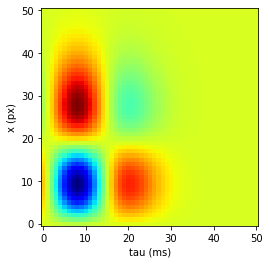

In [7]:
filts = np.load(os.path.join(data.data_path, 'filters.npz'))
k1 = filts['wb2'] * 25
plt.imshow(k1, aspect='equal')
plt.xlabel("tau (ms)")
plt.ylabel("x (px)")

Let's try to describe what kinds of visual stimuli would best excite a neuron with this RF.

We're going to simulate the response to some Gaussian white noise. This is equivalent to presenting a field of vertical or horizontal bars that are various shades of gray. I'm only going to show the first 1000 samples so you have a better idea of what this looks like.

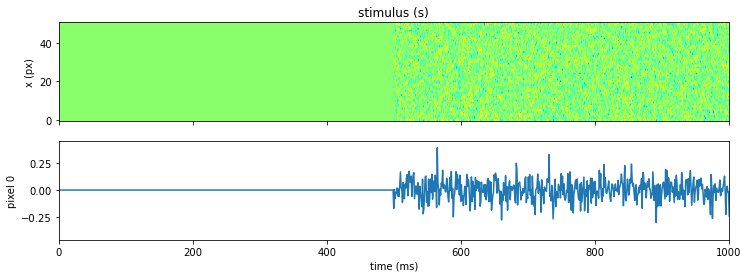

In [30]:
nx, nt = k1.shape
nsamples = nt * 1000
np.random.seed(1)
stim_raw = np.random.randn(nx, nsamples)
stim = stim_raw * 0.1
stim[:,:500] = 0
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 4))
axes[0].imshow(stim)
axes[0].set_ylabel("x (px)")
axes[0].set_title("stimulus (s)")
axes[1].plot(stim[0,:])
axes[1].set_ylabel("pixel 0")
axes[1].set_xlim(0, 1000)
axes[1].set_xlabel("time (ms)");

Now let's do the convolution. Remember, to implement in Python we need to convolve each spatial position and then sum them up:

\begin{align}
r_{i}(t) & = \sum_k h(x_i, \tau_k) s(x_i, t - \tau_k) \\
r(t) & = \sum_i r_{i}(t)
\end{align}

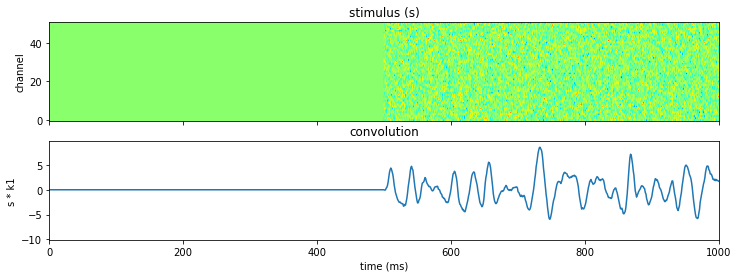

In [23]:
# convolve each pixel (row) separately
convrows = [np.convolve(k1[i], stim[i]) for i in range(nx)]
# sum across rows
conv = np.row_stack(convrows).sum(0)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 4))
axes[0].imshow(stim)
axes[0].set_ylabel("channel")
axes[0].set_title("stimulus (s)")
axes[1].plot(conv[:nsamples])
axes[1].set_title("convolution")
axes[1].set_ylabel("s * k1")
axes[1].set_xlim(0, 1000)
axes[1].set_xlabel("time (ms)");

Compare the result of the convolution to the stimulus and the RF. Is it what you would expect?

Next comes the "N" phase of the LNP model: we have to convert the convolution to an estimated rate by passing it through a nonlinear function. We'll use `exp`.

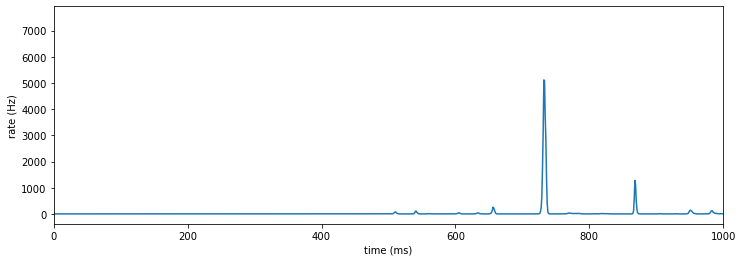

In [25]:
r_0 = 1
r_est = np.exp(conv[:nsamples] + np.log(r_0))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.plot(r_est)
axes.set_ylabel("rate (Hz)")
axes.set_xlim(0, 1000)
axes.set_xlabel("time (ms)");

And then generate spikes using our standard Bernoulli approximation:

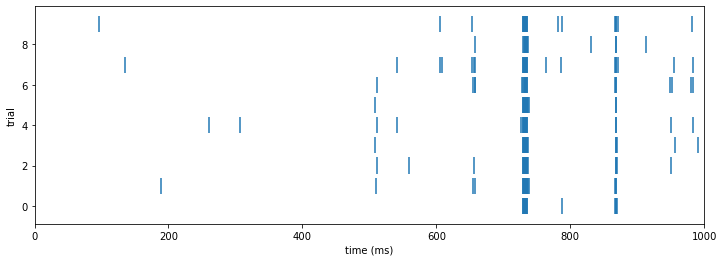

In [27]:
lmb = r_est * 0.001
n_trials = 10
spikes = []
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
for i in range(n_trials):
    runif = np.random.uniform(size=nsamples)
    spk = (lmb > runif).nonzero()[0]
    axes.vlines(spk, i - 0.4, i + 0.4)
    spikes.append(spk)
axes.set_xlim(0, 1000)
axes.set_ylabel("trial")
axes.set_xlabel("time (ms)");

**Exercise 1**

A. Calculate and plot a PSTH of the response. Label your axes for full credit. How does this compare to the estimated rate function?

B. Calculate the average firing rate across the whole stimulus.

C. Generate 10 more trials, but with a constant offset of -0.1 added to the output of the convolution. Plot the PSTH and compare it to the result in A.

## Estimating RFs

As Chapter 2 in Dayan and Abbott discusses in more detail, receptive fields can predict many of the tuning properties of visual neurons. This suggests two key conclusions:

1. Visual neurons (up to a point) are pretty linear.
2. Linear models have a lot of explanatory power.

As a consequence, we often want to try to estimate the linear RF of sensory neurons. Even if the neuron isn't totally linear, it's a good place to start. But how do we infer the kernel in a system where we can't stimulate with a delta function?

### Example

Let's see how we would do spike-triggered averaging using the response we just simulated. First, let's look at the stimulus that precedes one of the spikes in the response:

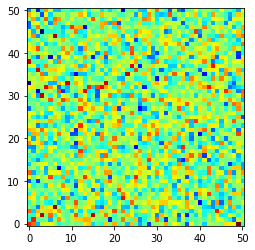

In [28]:
t = spikes[0][5]
sts = stim[:,t-nt:t]
plt.imshow(sts, aspect="equal")

Doesn't look like much, right? 

But what happens if we average over many, many spikes?

Text(0, 0.5, 'x (px)')

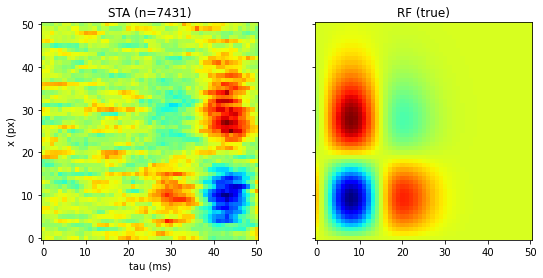

In [29]:
# using an accumulator pattern to count spikes 
n_spikes = 0
# each stimulus will be added into this empty array
sta = np.zeros_like(k1)
for trial in spikes:
    for t in trial:
        # exclude spikes that are too close to the start
        if t - nt < 0: continue
        n_spikes += 1
        sta += stim[:,t-nt:t]
# average by dividing the sum by N
sta /= n_spikes
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(9, 4))
axes[0].imshow(sta, aspect="equal")
axes[0].set_title("STA (n=%d)" % n_spikes)
axes[1].imshow(k1, aspect='equal')
axes[1].set_title("RF (true)")
axes[0].set_xlabel("tau (ms)")
axes[0].set_ylabel("x (px)");

Voila! The average stimulus preceding the spikes produced by this neuron looks like a time-flipped version of the receptive field.

If the stimulus is random and uncorrelated, given enough spikes the reverse correlation will always recover the receptive field.

What happens if we reduce the average firing rate (for example by setting the baseline $r_0$ to less than 1 Hz)? What happens if we "record" for more or less time?

## Stimulus correlations

Real-world stimuli rarely look like white noise. In the visual domain, stimuli are dominated by low frequencies, because objects tend to be fairly similar intensity surrounded by sharp edges.

In other words, pixels tend to be correlated with neighboring pixels and tend to change slowly over time. What happens if we try to use a stimulus that has some correlations?

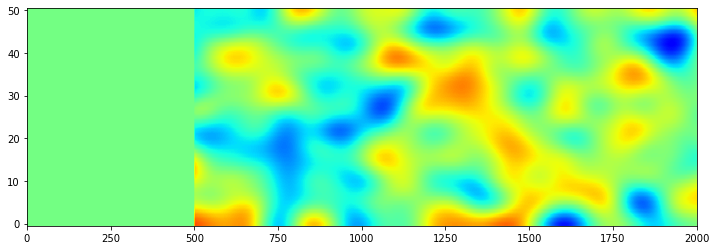

In [31]:
from scipy import ndimage
stim_filt = ndimage.gaussian_filter(stim_raw, sigma=(3, 50))
stim_filt[:,:500] = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.imshow(stim_filt)
axes.set_xlim(0, 2000);

**Exercise 2**

A. Simulate 10 trials of the neuron's response to the filtered stimulus, adding a constant offset of 1.0 to the convolution (otherwise the model won't fire). Use the code above as a model.

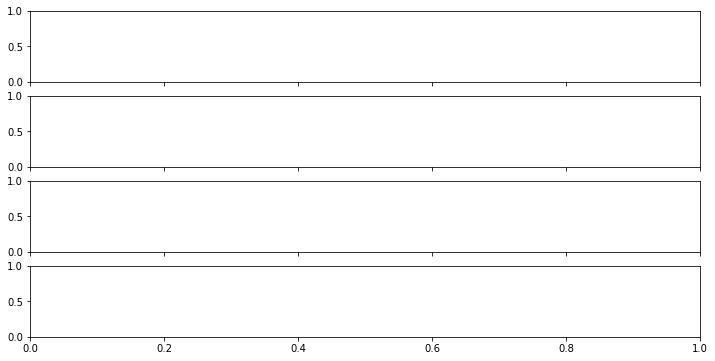

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 6))
# Plot the stimulus in axes[0], the convolution in axes[1], the estimated rate in axes[2], and the spikes in axes[3]
# Label your axes for full credit.


B. Calculate and plot the spike-triggered average from this response. Compare it with the original kernel.

What happened?? The STA looks nothing like the kernel, even though we averaged data from roughly the same number of spikes.

**Very important conclusion**: The spike-triggered average only recovers the kernel of an LTI system if there are no correlations in the stimulus. 

To see why this is, think about how the average would be affected if the ensemble of black points is not spherical:

<img src="images/l8_sta_ensemble.png" alt="spike-triggered average" style="width: 450px;" />

## Kernel estimation as linear regression

The solution to the foregoing problem is to correct for the correlations in the stimulus. How do we do this? It took the field a suprisingly long time to figure this out.

It can be helpful to recast the problem as one of linear regression. Remember the expansion of convolution:

$$r(t) = h_1 s(t) + h_2 s(t-\Delta) + h_3 s(t-2\Delta) + \cdots + h_N(t-N\Delta)$$ 

Here we've represented the kernel with subscripts starting with 1 but kept the functional notation for the stimulus.

We can rewrite this sum as a dot product,

$$r(t) = \mathbf{s}(t) \cdot \mathbf{h}$$

where $\mathbf{s}(t)$ refers to the **time-lagged** stimulus. That is $\mathbf{s}(t) = \{s(t), s(t - \Delta), \ldots, s(t - N\Delta)\}$.

### Example

Let's look at a concrete example in numpy using a really short stimulus and kernel.

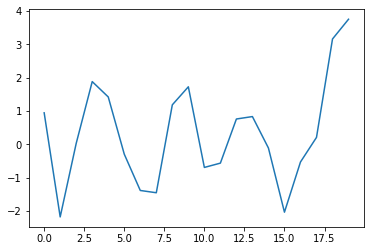

In [35]:
# the kernel
h = np.asarray([0, 1, -0.5])
# the full stimulus
stim = np.random.randn(20)
plt.plot(stim)

In [36]:
stim

array([ 0.94365853, -2.17527031,  0.02869656,  1.87926989,  1.41925165,
       -0.29469039, -1.38293212, -1.45104041,  1.18300771,  1.72311079,
       -0.69261326, -0.56365281,  0.75852736,  0.8312548 , -0.11174941,
       -2.03305442, -0.53022005,  0.20707845,  3.15604927,  3.74740329])

Let's calculate the response at $t = 2$. $\mathbf{h}$ is time-invariant, so we leave it as is. $\mathbf{s}(2)$ is `[stim[0], stim[1], stim[2]]` but **in reverse**. In slice notation, this is `stim[2::-1]` (i.e., start at index 2 and go to the beginning in steps of -1).

In [37]:
print("r_2 =", np.dot(h, stim[2::-1]))

r_2 = -2.6470995763380163


### Vectorizing the model

Instead of writing the response and stimulus as a function of time, let's think of them as a series of observations made at discrete intervals. Thus,

$$r(t) = \mathbf{s}(t) \cdot \mathbf{h}$$

becomes

$$r_i = \mathbf{s}_i \cdot \mathbf{h}$$

where $r_i$ is the rate at time $t_i$ and $\mathbf{s}_i$ is the stimulus from $t_{i-N}$ to $t_i$.

We can further simplify our notation by stacking all the observations in a vector $\mathbf{r}$:

$$\mathbf{r} = \mathbf{S} \mathbf{h}$$

The matrix $\mathbf{S}$ has as many rows as there are time points in the observation vector $\mathbf{r}$ and as many columns as there are time points in the kernel $\mathbf{h}$. In each row, it contains the stimulus at the current time and at a set of previous lags. 

Let's see what this would look like for our toy problem:

In [38]:
from IPython.display import display

print("stimulus:")
display(stim)
ntau = len(h)
nt = len(stim)
S = np.zeros((nt - ntau, ntau))
for i in range(ntau, nt):
    S[i-ntau] = stim[i-ntau:i][::-1]
print("stimulus matrix:")
display(S)


stimulus:


array([ 0.94365853, -2.17527031,  0.02869656,  1.87926989,  1.41925165,
       -0.29469039, -1.38293212, -1.45104041,  1.18300771,  1.72311079,
       -0.69261326, -0.56365281,  0.75852736,  0.8312548 , -0.11174941,
       -2.03305442, -0.53022005,  0.20707845,  3.15604927,  3.74740329])

stimulus matrix:


array([[ 0.02869656, -2.17527031,  0.94365853],
       [ 1.87926989,  0.02869656, -2.17527031],
       [ 1.41925165,  1.87926989,  0.02869656],
       [-0.29469039,  1.41925165,  1.87926989],
       [-1.38293212, -0.29469039,  1.41925165],
       [-1.45104041, -1.38293212, -0.29469039],
       [ 1.18300771, -1.45104041, -1.38293212],
       [ 1.72311079,  1.18300771, -1.45104041],
       [-0.69261326,  1.72311079,  1.18300771],
       [-0.56365281, -0.69261326,  1.72311079],
       [ 0.75852736, -0.56365281, -0.69261326],
       [ 0.8312548 ,  0.75852736, -0.56365281],
       [-0.11174941,  0.8312548 ,  0.75852736],
       [-2.03305442, -0.11174941,  0.8312548 ],
       [-0.53022005, -2.03305442, -0.11174941],
       [ 0.20707845, -0.53022005, -2.03305442],
       [ 3.15604927,  0.20707845, -0.53022005]])

Take a close look at the stimulus matrix. Notice how the values shift over by one in each row?

This kind of matrix is called a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix), and it's the linear algebra equivalent of convolution.

There's a function in `scipy` that can generate this matrix and even do some padding.

In [39]:
from scipy.linalg import toeplitz
S = toeplitz(stim, np.asarray([stim[0], 0, 0]))
print(S)

[[ 0.94365853  0.          0.        ]
 [-2.17527031  0.94365853  0.        ]
 [ 0.02869656 -2.17527031  0.94365853]
 [ 1.87926989  0.02869656 -2.17527031]
 [ 1.41925165  1.87926989  0.02869656]
 [-0.29469039  1.41925165  1.87926989]
 [-1.38293212 -0.29469039  1.41925165]
 [-1.45104041 -1.38293212 -0.29469039]
 [ 1.18300771 -1.45104041 -1.38293212]
 [ 1.72311079  1.18300771 -1.45104041]
 [-0.69261326  1.72311079  1.18300771]
 [-0.56365281 -0.69261326  1.72311079]
 [ 0.75852736 -0.56365281 -0.69261326]
 [ 0.8312548   0.75852736 -0.56365281]
 [-0.11174941  0.8312548   0.75852736]
 [-2.03305442 -0.11174941  0.8312548 ]
 [-0.53022005 -2.03305442 -0.11174941]
 [ 0.20707845 -0.53022005 -2.03305442]
 [ 3.15604927  0.20707845 -0.53022005]
 [ 3.74740329  3.15604927  0.20707845]]


With our Toeplitz matrix, convolution is as simple as matrix multiplication:

In [40]:
# the slow way
r1 = np.convolve(stim, h)[:nt]
# and the fast way
r2 = np.dot(S, h)
# should give the same result....
assert np.all(r1 == r2)
display(r1)

array([ 0.        ,  0.94365853, -2.64709958,  1.11633172,  1.86492161,
        0.47961671, -1.00431622, -1.23558692, -0.75957435,  1.90852791,
        1.13160693, -1.55416865, -0.21734618,  1.04035377,  0.45199112,
       -0.5273768 , -1.97717971,  0.48630716,  0.47218848,  3.05251005])

Is r_2 the same as what we manually calculated above?

### Linear regression with time-varying stimuli

What does this have to do with linear regression? The advantage of this notation is that it's easy to see how our data consist of a series of observations made for different values of $\mathbf{s}$. Some of the variance in these observations is explained by variation in the stimulus; the rest is random noise. We represent this noise as an additional variable that's added at each time point. 

$$r_i = \mathbf{s}_i \cdot \mathbf{h} + \varepsilon_i$$

Or equivalently,

$$\mathbf{r} = \mathbf{S} \mathbf{h} + \mathbf{\varepsilon}$$

Given this model, our goal is to estimate $\mathbf{h}$. That is, to find values that maximize the amount of variance explained by the stimulus and minimize the amount of random error ($\mathbf{\varepsilon}$).

If we assume that the noise is normally distributed and independent, then what we need to do is minimize the sum of the squares of the error. This is called **ordinary least squares** (OLS).

Hopefully, you've seen that our model is a pretty vanilla linear model. The OLS solution is well-known:

$$\hat{h} = (\mathbf{S}^T \mathbf{S})^{-1} \mathbf{S}^T \mathbf{r} = \left(\sum_i \mathbf{s}_j \cdot \mathbf{s}_i \right)^{-1} \left(\sum_i \mathbf{s}_i r_i \right)$$

- The first term is the autocovariance matrix for the independent variables. 
- The second term is the covariance between the dependent and independent variables. 
- Here, these correspond to the **autocorrelation** and the **cross-correlation**

If the stimulus is white noise, the correlation between any two instants in time is zero, so $\mathbf{S}^T\mathbf{S} = \sigma^2\mathbf{I}$ ($\mathbf{I}$ is the identity matrix and $\sigma^2$ is the variance of the stimulus).

The $^{-1}$ operator stands for **matrix inversion**. This is what "undoes" the effects of the correlations in the stimulus. Matrix inversion is computationally expensive and numerically hairy. There are some tricks for dealing with the latter, but for now let's look at a quick example:

### Example

Let's use a nice alpha function as our kernel.

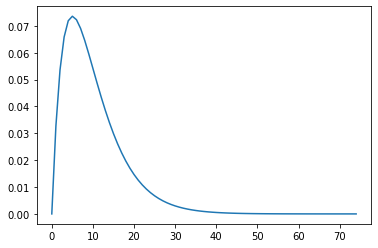

In [41]:
tau = 5
dt = 1.0
kt = np.arange(0, 75, dt)
k = kt / tau**2 * np.exp(-kt / tau)
nkt = len(k)
plt.plot(kt, k);

And let's consider two stimuli: one that's uncorrelated and one that is correlated (i.e. smoothed).

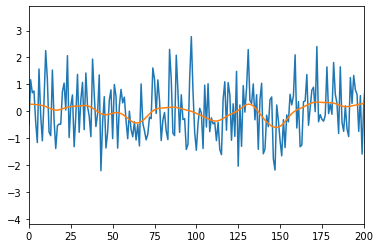

In [42]:
nt = 10000
t = np.arange(0, nt, 1.0)
stim_u = np.random.randn(nt)
stim_c = ndimage.gaussian_filter(stim_u, 5)
plt.plot(t, stim_u, t, stim_c)
plt.xlim(0, 200);

We'll generate our Toeplitz matrices for both stimuli and use them to simulate a response. Note that we're adding a bit of noise.

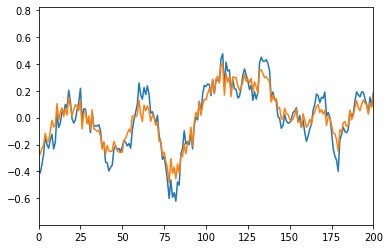

In [43]:
S_u = toeplitz(stim_u[nkt:], stim_u[nkt-1::-1])
S_c = toeplitz(stim_c[nkt:], stim_c[nkt-1::-1])

nrt = nt - nkt
eps = np.random.randn(nrt) * 0.05
r_u = np.dot(S_u, k) + eps
r_c = np.dot(S_c, k) + eps
plt.plot(r_u)
plt.plot(r_c)
plt.xlim(0, 200);

The STA is just the inverse of the convolution:

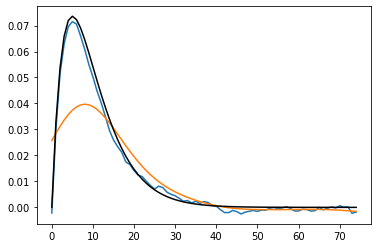

In [44]:
STA_u = np.dot(S_u.T, r_u)
STA_c = np.dot(S_c.T, r_c)
plt.plot(kt, STA_u / nt, kt, STA_c / nt, kt, k, 'k')

Notice how the STA for the uncorrelated stimulus is pretty good, but the STA for the correlated one is badly distorted.

Now let's find the OLS estimate by dividing out the stimulus autocorrelations.

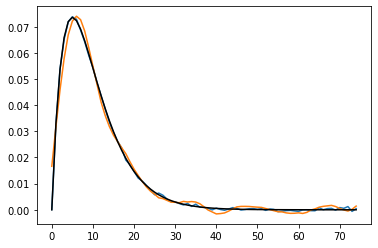

In [45]:
from scipy import linalg

# this works because the covariance matrix is relatively easy to invert
cov_u = np.dot(S_u.T, S_u)
ols_u = np.dot(linalg.inv(cov_u), STA_u)

# we have to do a little regularization to avoid numerical issues
cov_c = np.dot(S_c.T, S_c) + 10 * np.eye(nkt)
ols_c = np.dot(linalg.inv(cov_c), STA_c)

plt.plot(kt, ols_u, kt, ols_c, kt, k, 'k')

Now the estimate from the correlated stimulus is much closer to the true kernel!

### Summary

- The receptive field of a neuron can be approximated as the linear kernel of a linear-nonlinear-Poisson model
- If the stimulus distribution is spherical and Gaussian, the RF/kernel can be estimated using spike-triggered averaging
- If the stimulus distribution is not spherical, the RF/kernel can be estimated using linear correlation

**Exercise 3**

Use linear regression to recover the visual receptive field from the response to `stim_filt` in Exercise 2.

First, here's a little help in building your design matrix. If your receptive field has $m$ channels and $k$ time points, then $\mathbf{h}$ will be dimension $mk$. This is called "unwrapping" or "flattening" the receptive field.

In [49]:
M, K = k1.shape
display((M, K))
h = k1.flatten()
display(h)

(51, 51)

array([ 1.73614949e-02, -3.13985339e-03, -2.65833844e-02, ...,
       -1.52807466e-07, -7.15323536e-08, -3.27799371e-08])

To get your receptive field back, you have to *reshape* $\mathbf{h}$:

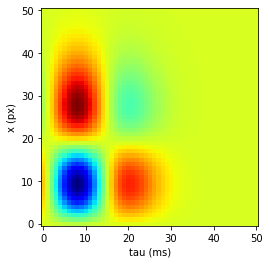

In [57]:
plt.imshow(h.reshape(M, K), aspect='equal')
plt.xlabel("tau (ms)")
plt.ylabel("x (px)");

Your stimulus will have to have $m$ channels to match the receptive field. If it has $n$ time points, then $\mathbf{X}$ will be dimension $n \times mk$. This is called a *block Toeplitz* matrix, and it's formed by concatenating the Toeplitz matrices for each channel along the columns dimension.

$$
\mathbf{X} = \begin{pmatrix}
s_1(0) & s_1(0 - \Delta) & \ldots & s_1(0 - k\Delta) & s_2(0) & \ldots & s_m(0 - k\Delta) \\
s_1(1) & s_1(1 - \Delta) & \ldots & s_1(1 - k\Delta) & s_2(1) & \ldots & s_m(1 - k\Delta) \\
\vdots & & \vdots & & & \vdots \\
s_1(n) & s_1(n - \Delta) & \ldots & s_1(n - k\Delta) & s_2(n) & \ldots & s_m(n - k\Delta)
\end{pmatrix}
$$

In [55]:
assert stim_filt.shape[0] == M, "Number of channels doesn't match between stim and RF"
M, N = stim_filt.shape
toeps = []
for i in range(M):
    first = np.zeros(K)
    first[0] = stim_filt[i, 0]
    Xi = toeplitz(stim_filt[i], first)
    toeps.append(Xi)
X = np.column_stack(toeps)
display(X.shape)
assert X.shape[1] == h.size, "design matrix does not have the right shape"

(51000, 2601)

**A.** Calculate the spike-triggered average of the response to `stim_filt` (from Exercise 2) using `np.dot`. Plot the result and confirm that you get the same result as before.

**B.** Use the code in the previous section to calculate the OLS estimate of the RF. You will need to use regularization. Plot your estimate and the original RF.